## [ResNet-8](https://ieeexplore.ieee.org/abstract/document/10064103)

## Import Libs

In [23]:
import pandas as pd
import os
import seaborn as sns
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Flatten, Add, Dense, ReLU, Input 
from tensorflow.keras.layers import Dropout,AveragePooling2D,GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, r2_score

## Import Dataset

In [24]:
df = pd.read_csv("/kaggle/input/40keclabeldataset/image_labels.csv")
image_folder = "/kaggle/input/40keclabeldataset/imgs"

## Import Images

In [25]:
# Đọc ảnh từ thư mục và lưu trữ trong danh sách
images = []
# Lặp qua từng hàng trong dataframe để đọc ảnh và lấy nhãn tương ứng
for index, row in df.iterrows():
    img_path = os.path.join(image_folder, row['Image'])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Đọc ảnh xám
    images.append(img)
    
# Chuyển đổi danh sách thành numpy arrays
images = np.array(images)
images = images.astype('float32') / 255.0  # Chuẩn hóa dữ liệu ảnh
images = np.expand_dims(images, axis=-1)   # Thêm một chiều cho kênh ảnh

In [26]:
images.shape

(245, 64, 64, 1)

In [27]:
# Lấy cột nồng độ khí
concentrations = df[['CO2 conc (ppm)', 'Ethylene conc (ppm)']]

# Khởi tạo và áp dụng MinMaxScaler
scaler = MinMaxScaler()
y = scaler.fit_transform(concentrations)


In [28]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.2, random_state=42)

# Check the shapes to confirm correct splitting
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")

Training set: (196, 64, 64, 1), (196, 2)
Testing set: (49, 64, 64, 1), (49, 2)


## ResNet8


https://ieeexplore.ieee.org/abstract/document/10064103

![ResNet-8.Stucture](https://ieeexplore.ieee.org/mediastore/IEEE/content/media/6287639/10005208/10064103/rhee4abcd-3253968-large.gif)

In [29]:
# Đầu vào
inputs = Input(shape=(64, 64, 1))

# Khối Convolutional (mô phỏng ResNet-8)
x = Conv2D(64, (3, 3), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(3, 3))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = Flatten()(x)

# Nhánh đầu ra cho CO concentration
output1 = Dense(64, activation='relu')(x)
output1 = Dense(32, activation='relu')(output1)
output1 = Dense(1, activation='linear',name="Gas1_concentration")(output1)

# Nhánh đầu ra cho Ethylene concentration
output2 = Dense(64, activation='relu')(x)
output2 = Dense(32, activation='relu')(output2)
output2 = Dense(1, activation='linear',name="Gas2_concentration")(output2)

# Tạo mô hình với hai đầu ra
model = Model(inputs=inputs, outputs=[output1, output2])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss={'Gas1_concentration': 'mse', 'Gas2_concentration': 'mse'},
              metrics={'Gas1_concentration': 'mae', 'Gas2_concentration': 'mae'})

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 62, 62,    │        640 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 20, 20,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 18, 18,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     36,928 │ conv2d_5[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 14, 14,    │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 12, 12,    │     73,856 │ conv2d_7[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 10, 10,    │    147,584 │ conv2d_8[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 8, 8, 128) │    147,584 │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8192)      │          0 │ conv2d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │    524,352 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │    524,352 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │      2,080 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │      2,080 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Gas1_concentration  │ (None, 1)         │         33 │ dense_5[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Gas2_concentration  │ (None, 1)         │         33 │ dense_7[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,533,378 (5.85 MB)

 Trainable params: 1,533,378 (5.85 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Huấn luyện mô hình với hai đầu ra
history = model.fit(
    X_train, 
    {'Gas1_concentration': y_train[:, 0], 'Gas2_concentration': y_train[:, 1]},
    epochs= 100, 
    batch_size=32, 
    validation_data=(X_test, {'Gas1_concentration': y_test[:, 0], 'Gas2_concentration': y_test[:, 1]})
)


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 538ms/step - Gas1_concentration_mae: 0.3180 - Gas2_concentration_mae: 0.3426 - loss: 0.3343 - val_Gas1_concentration_mae: 0.2974 - val_Gas2_concentration_mae: 0.4406 - val_loss: 0.4093
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - Gas1_concentration_mae: 0.3007 - Gas2_concentration_mae: 0.3075 - loss: 0.2770 - val_Gas1_concentration_mae: 0.2808 - val_Gas2_concentration_mae: 0.2598 - val_loss: 0.1888
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - Gas1_concentration_mae: 0.2357 - Gas2_concentration_mae: 0.2498 - loss: 0.1628 - val_Gas1_concentration_mae: 0.2808 - val_Gas2_concentration_mae: 0.2807 - val_loss: 0.2114
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - Gas1_concentration_mae: 0.2543 - Gas2_concentration_mae: 0.2316 - loss: 0.1657 - val_Gas1_concentration_mae: 0.2833 - val_Gas2_concentration_mae: 0.1916 - val_loss: 0.1587
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - Gas1_concentration_mae: 0.2664 - Gas2_concentration

In [31]:
from sklearn.metrics import mean_absolute_error, r2_score

# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)

# Tách dự đoán cho từng khí
y_pred_gas1 = y_pred[0] # Dự đoán nồng độ khí 1
y_pred_gas2 = y_pred[1] # Dự đoán nồng độ khí 2


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


In [32]:
# Inverse transform cho giá trị ground truth và dự đoán
# Ghép lại dự đoán thành mảng 2 chiều để inverse transform
y_pred_combined = np.column_stack((y_pred_gas1, y_pred_gas2))

# Inverse transform cho ground truth và dự đoán
y_true_rescaled = scaler.inverse_transform(y_test)  # Ground truth
y_pred_rescaled = scaler.inverse_transform(y_pred_combined)  # Dự đoán đã ghép

# Tách lại sau khi rescale để dùng cho các bước tiếp theo (nếu cần)
y_pred_gas1_rescaled = y_pred_rescaled[:, 0]
y_pred_gas2_rescaled = y_pred_rescaled[:, 1]
y_true_gas1_rescaled = y_true_rescaled[:, 0]
y_true_gas2_rescaled = y_true_rescaled[:, 1]

In [33]:
# Tính MAE cho từng khí
mae_gas1 = mean_absolute_error(y_true_gas1_rescaled, y_pred_gas1_rescaled)
mae_gas2 = mean_absolute_error(y_true_gas2_rescaled, y_pred_gas2_rescaled)

# Tính R2 score cho từng khí
r2_gas1 = r2_score(y_true_gas1_rescaled, y_pred_gas1_rescaled)
r2_gas2 = r2_score(y_true_gas2_rescaled, y_pred_gas2_rescaled)

print(f"CO - MAE: {mae_gas1:.4f}, R2: {r2_gas1:.4f}")
print(f"Ethylene - MAE: {mae_gas2:.4f}, R2: {r2_gas2:.4f}")

CO - MAE: 29.0122, R2: 0.9296
Ethylene - MAE: 1.3198, R2: 0.8965


In [34]:
import matplotlib.pyplot as plt

def plot_groundtruth_vs_prediction(y_true, y_pred, gas_name="Gas Concentration"):
    plt.figure(figsize=(10, 5))
    
    # Vẽ Groundtruth
    plt.plot(y_true, label=f"Groundtruth {gas_name}", color='blue')
    
    # Vẽ Prediction
    plt.plot(y_pred, label=f"Prediction {gas_name}", color='red', linestyle='--')
    
    plt.xlabel("Sample Index")
    plt.ylabel("Concentration (scaled)")
    plt.title(f"Comparison of Groundtruth vs Prediction for {gas_name}")
    plt.legend()
    plt.show()

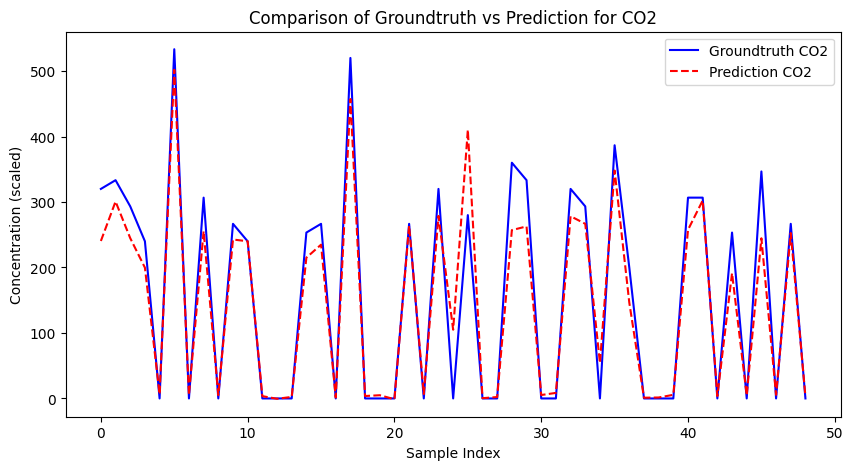

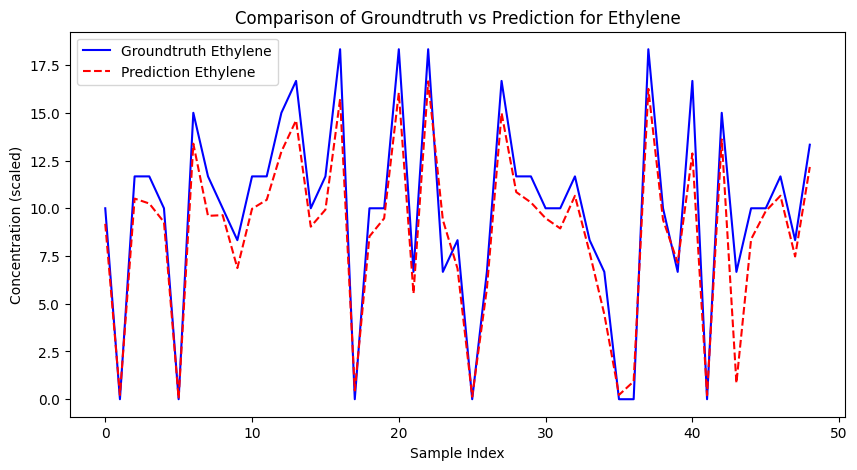

In [35]:
# Ví dụ cho việc vẽ lại biểu đồ sau khi inverse transform
plot_groundtruth_vs_prediction(y_true_rescaled[:, 0], y_pred_gas1_rescaled, gas_name="CO2")
plot_groundtruth_vs_prediction(y_true_rescaled[:, 1], y_pred_gas2_rescaled, gas_name="Ethylene")

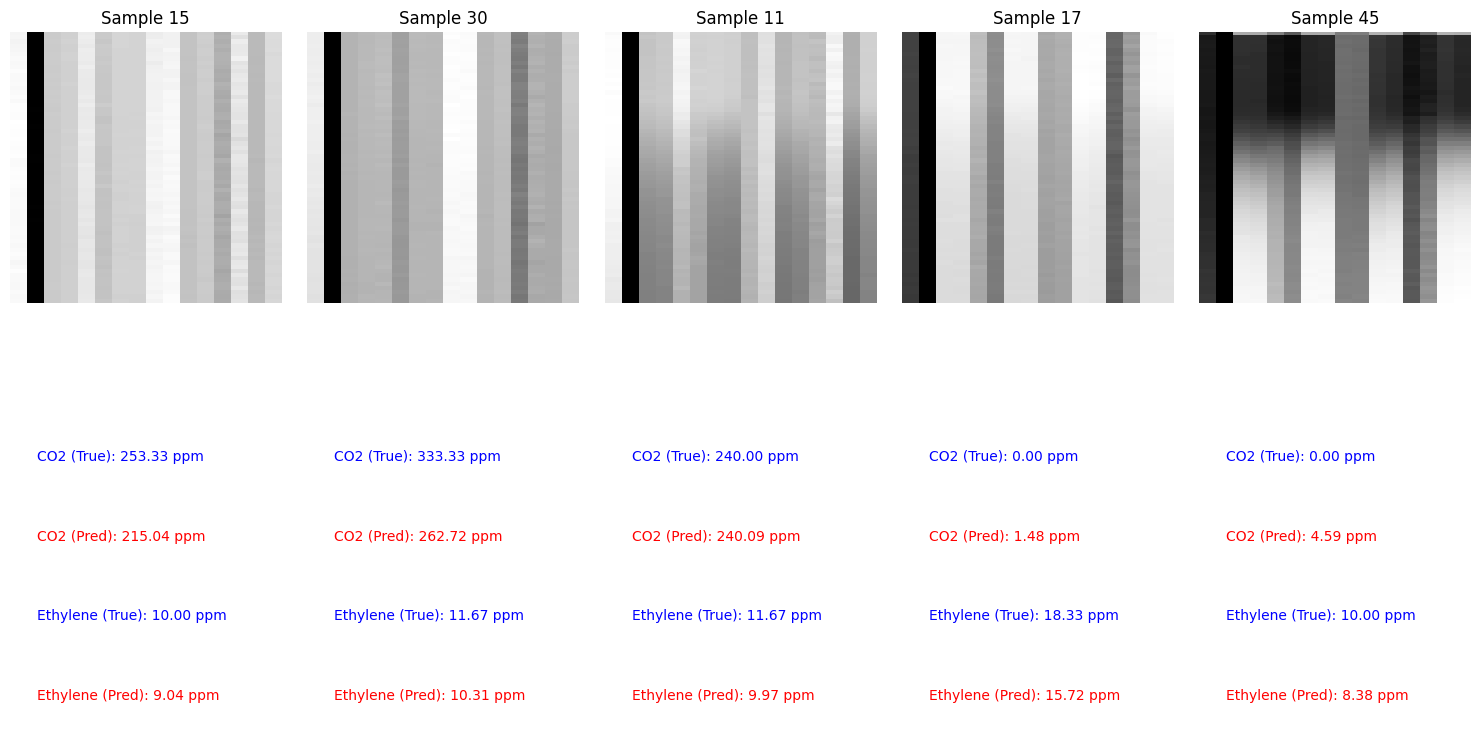

In [36]:
# Chọn 5 mẫu ngẫu nhiên từ tập kiểm tra
num_samples = 5
random_indices = np.random.choice(X_test.shape[0], num_samples, replace=False)

# Tạo biểu đồ cho 5 mẫu ngẫu nhiên
plt.figure(figsize=(15, 8))

for i, idx in enumerate(random_indices):
    # Chọn ảnh, ground truth và dự đoán của mẫu
    img = X_test[idx].reshape(64, 64)  # Chuyển thành kích thước 64x64
    true_co2 = y_true_rescaled[idx, 0]
    true_ethylene = y_true_rescaled[idx, 1]
    pred_co2 = y_pred_gas1_rescaled[idx]
    pred_ethylene = y_pred_gas2_rescaled[idx]
    
    # Hiển thị ảnh
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f"Sample {idx+1}")

    # Hiển thị Ground Truth và Prediction cho từng khí
    plt.subplot(2, 5, i + 6)
    plt.text(0.1, 0.7, f"CO2 (True): {true_co2:.2f} ppm", color="blue")
    plt.text(0.1, 0.5, f"CO2 (Pred): {pred_co2:.2f} ppm", color="red")
    plt.text(0.1, 0.3, f"Ethylene (True): {true_ethylene:.2f} ppm", color="blue")
    plt.text(0.1, 0.1, f"Ethylene (Pred): {pred_ethylene:.2f} ppm", color="red")
    plt.axis('off')

plt.tight_layout()
plt.show()

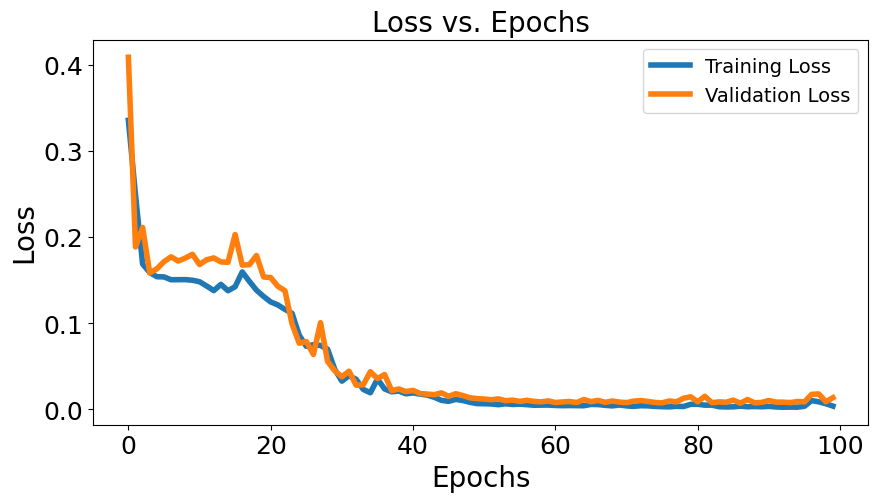

In [37]:
# Save the figure to a pickle file
fig_object = plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=4)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=4)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.title('Loss vs. Epochs', fontsize=20)
plt.legend(fontsize=14)
plt.tick_params(axis='both', labelsize=18)
plt.show()

pickle.dump(fig_object, open('sinus.pickle', 'wb'))
fig_object.savefig('plot.svg', format='svg')

In [38]:
import pickle
import matplotlib.pyplot as plt

# Now load the figure back
with open('sinus.pickle', 'rb') as f:
    fig_object = pickle.load(f)

# Display the figure
#plt.show()

# Now you can modify the figure if needed:
fig_object.suptitle('Updated Loss vs. Epochs', fontsize=22)
fig_object.axes[0].set_xlabel('Epochs (Updated)', fontsize=18)
fig_object.axes[0].set_ylabel('Loss (Updated)', fontsize=18)


Text(38.0, 0.5, 'Loss (Updated)')

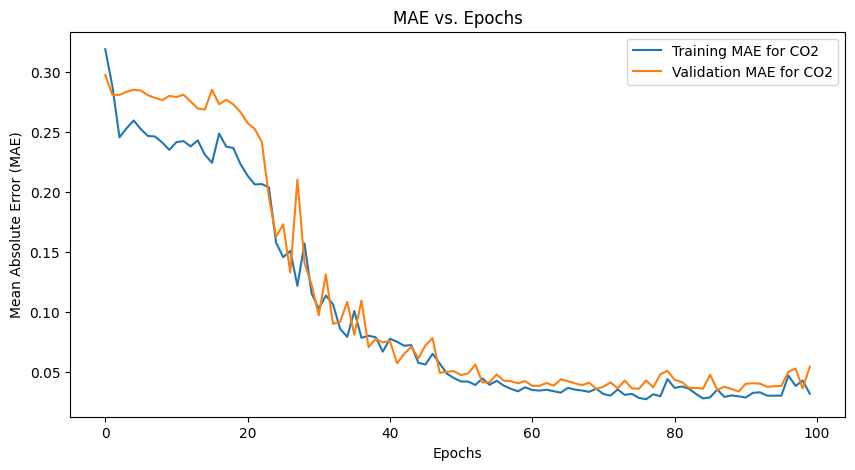

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['Gas1_concentration_mae'], label='Training MAE for CO2')
plt.plot(history.history['val_Gas1_concentration_mae'], label='Validation MAE for CO2')
# plt.plot(history.history['Gas2_concentration_mae'], label='Training MAE for Ethylene')
# plt.plot(history.history['val_Gas2_concentration_mae'], label='Validation MAE for Ethylene')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE vs. Epochs')
plt.legend()
plt.show()


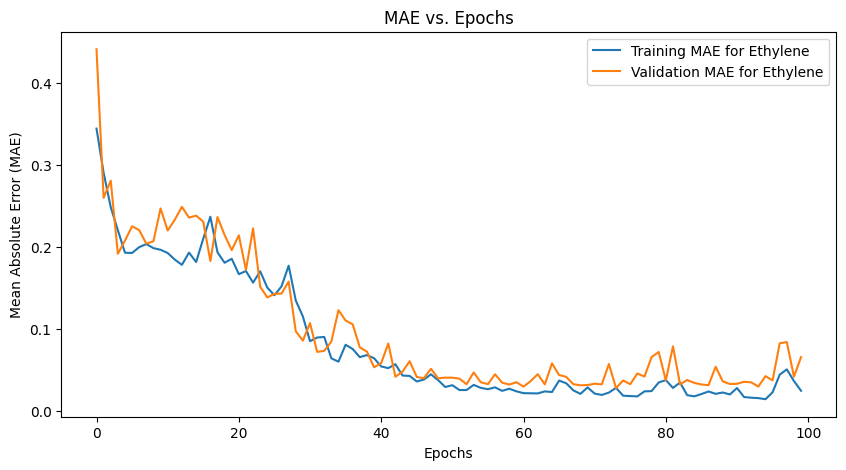

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['Gas2_concentration_mae'], label='Training MAE for Ethylene')
plt.plot(history.history['val_Gas2_concentration_mae'], label='Validation MAE for Ethylene')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE vs. Epochs')
plt.legend()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


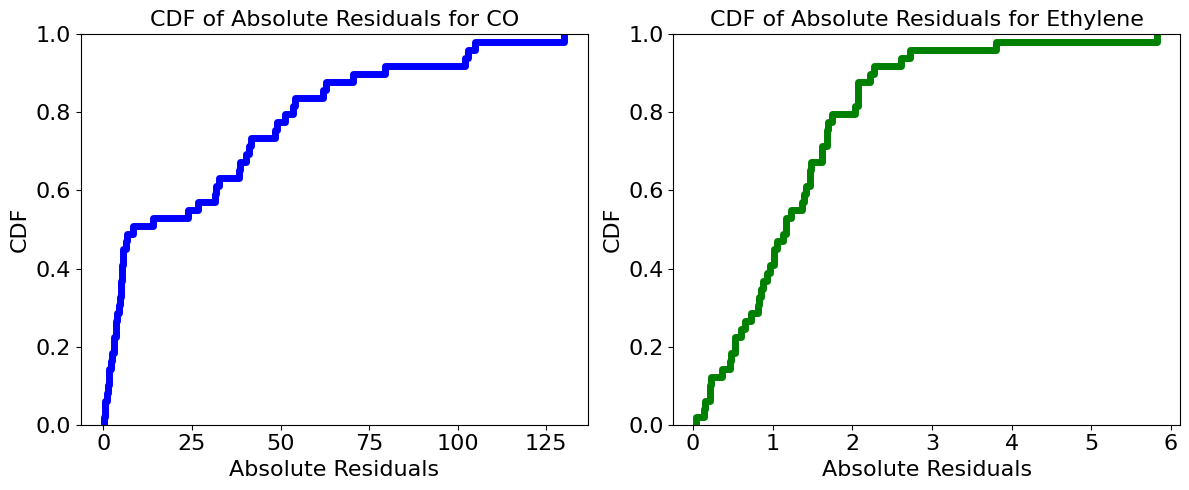

In [41]:
# Compute absolute residuals
abs_residuals_gas1 = np.abs(y_true_rescaled[:, 0] - y_pred_gas1_rescaled)
abs_residuals_gas2 = np.abs(y_true_rescaled[:, 1] - y_pred_gas2_rescaled)

# Plotting
plt.figure(figsize=(12, 5))

# CDF for Gas 1
plt.subplot(1, 2, 1)
sns.ecdfplot(abs_residuals_gas1, color='blue',linewidth=5)
plt.title("CDF of Absolute Residuals for CO", fontsize = 16)
plt.xlabel("Absolute Residuals", fontsize = 16)
plt.ylabel("CDF", fontsize = 16)
plt.tick_params(axis='both', labelsize=16)
# CDF for Gas 2
plt.subplot(1, 2, 2)
sns.ecdfplot(abs_residuals_gas2, color='green',linewidth=5)
plt.title("CDF of Absolute Residuals for Ethylene", fontsize = 16)
plt.xlabel("Absolute Residuals", fontsize = 16)
plt.ylabel("CDF", fontsize = 16)
plt.tick_params(axis='both', labelsize=16)
plt.tight_layout()
plt.show()

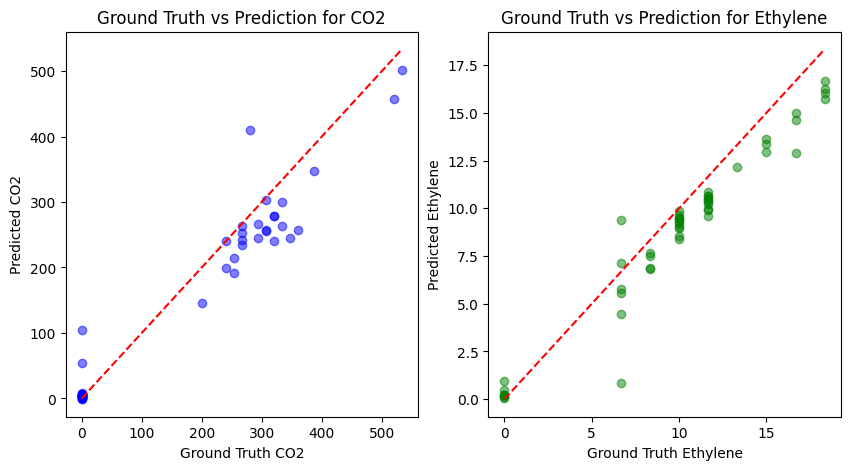

In [42]:
plt.figure(figsize=(10, 5))

# Biểu đồ cho CO2
plt.subplot(1, 2, 1)
plt.scatter(y_true_rescaled[:, 0], y_pred_gas1_rescaled, color='blue', alpha=0.5)
plt.plot([y_true_rescaled[:, 0].min(), y_true_rescaled[:, 0].max()],
         [y_true_rescaled[:, 0].min(), y_true_rescaled[:, 0].max()], 'r--')
plt.xlabel("Ground Truth CO2")
plt.ylabel("Predicted CO2")
plt.title("Ground Truth vs Prediction for CO2")

# Biểu đồ cho Ethylene
plt.subplot(1, 2, 2)
plt.scatter(y_true_rescaled[:, 1], y_pred_gas2_rescaled, color='green', alpha=0.5)
plt.plot([y_true_rescaled[:, 1].min(), y_true_rescaled[:, 1].max()],
         [y_true_rescaled[:, 1].min(), y_true_rescaled[:, 1].max()], 'r--')
plt.xlabel("Ground Truth Ethylene")
plt.ylabel("Predicted Ethylene")
plt.title("Ground Truth vs Prediction for Ethylene")

plt.show()


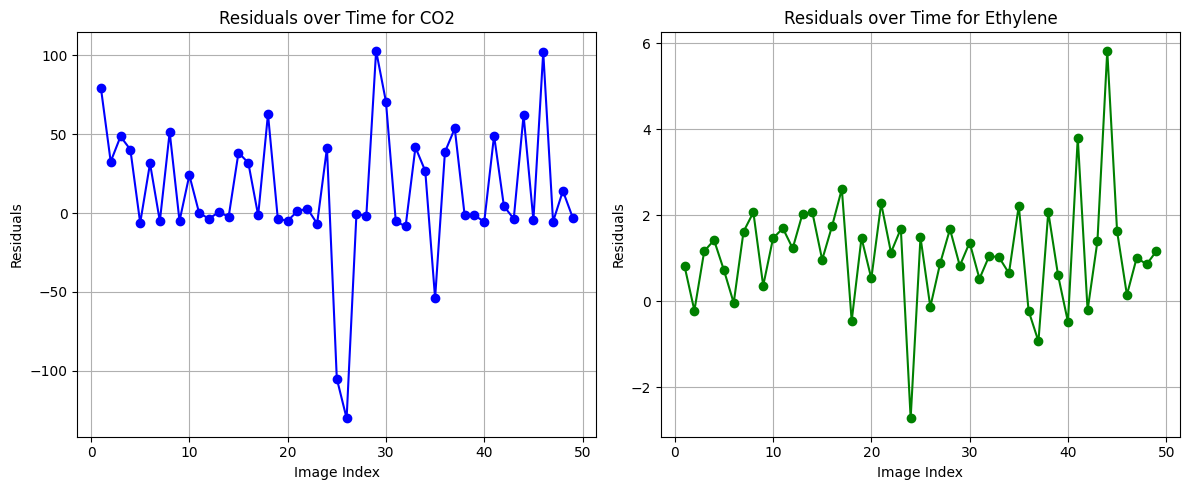

In [43]:
# Tính sai lệch cho từng khí
residuals_gas1 = y_true_rescaled[:, 0] - y_pred_gas1_rescaled
residuals_gas2 = y_true_rescaled[:, 1] - y_pred_gas2_rescaled

# Tạo danh sách các chỉ số ảnh (1, 2, 3, ...)
image_indices = list(range(1, len(residuals_gas1) + 1))

# Vẽ residuals theo thời gian cho từng khí
plt.figure(figsize=(12, 5))

# Plot residuals for Gas1 (CO2) over time
plt.subplot(1, 2, 1)
plt.plot(image_indices, residuals_gas1, marker='o', color='blue', label='Residuals CO2')
plt.xlabel("Image Index")
plt.ylabel("Residuals")
plt.title("Residuals over Time for CO2")
plt.grid(True)

# Plot residuals for Gas2 (Ethylene) over time
plt.subplot(1, 2, 2)
plt.plot(image_indices, residuals_gas2, marker='o', color='green', label='Residuals Ethylene')
plt.xlabel("Image Index")
plt.ylabel("Residuals")
plt.title("Residuals over Time for Ethylene")
plt.grid(True)

plt.tight_layout()
plt.show()

In [44]:
# import pandas as pd

# # Tạo DataFrame chứa residuals
# residuals_data = {
#     "image_index": list(range(1, len(residuals_gas1) + 1)),
#     "residuals_gas1": residuals_gas1,
#     "residuals_gas2": residuals_gas2
# }
# df = pd.DataFrame(residuals_data)

# # Lưu vào file CSV
# df.to_csv("residuals_model_Resnet8.csv", index=False)  # Đổi tên file theo từng model
